In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"

import os
import sys
import random
import warnings
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import ShuffleSplit
import cv2
from scipy import ndimage
import time
import datetime
from image import ImageDataGenerator

seed = 42
random.seed = seed
np.random.seed = seed

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print ('%s: %s' %(var,module.__version__))
    
# package version    
get_version('keras','numpy','matplotlib','cv2','theano')


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 20.0% of memory, cuDNN 5110)


keras: 2.1.3
numpy: 1.13.3
matplotlib: 2.1.0
cv2: 2.4.13
theano: 0.9.0.dev-425cb8effc7958e8ca376b023d8344b7620a9622


## Settings

In [2]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '../data/stage1_train/'
TEST_PATH = '../data/stage1_test/'

# normalization type
#norm_type='zeroMeanUnitStd'
norm_type=None

netinfo='trainTest5'
initialLearningRate=3e-4


# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Utilities

In [3]:
# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.05,
        zoom_range=0.05,
        channel_shift_range=0.0,
        fill_mode='constant',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,)
        #data_format="channels_first") 
    
# calcualte dice
def calc_dice(X,Y,d=0):
    N=X.shape[d]    
    # intialize dice vector
    dice=np.zeros([N,1])

    for k in range(N):
        x=X[k,0] >.5 # convert to logical
        y =Y[k,0]>.5 # convert to logical

        # number of ones for intersection and union
        intersectXY=np.sum((x&y==1))
        unionXY=np.sum(x)+np.sum(y)

        if unionXY!=0:
            dice[k]=2* intersectXY/(unionXY*1.0)
            #print 'dice is: %0.2f' %dice[k]
        else:
            dice[k]=1
            #print 'dice is: %0.2f' % dice[k]
        #print 'processing %d, dice= %0.2f' %(k,dice[k])
    return np.mean(dice),dice

def preprocess(X,xnormType=None):
    if xnormType=='minus1plus1':
        X=X.astype('float32')
        X/=np.max(X)
        X-=0.5
        X=X*2
    elif xnormType=='zeroMeanUnitStd':
        X=X.astype('float32')
        # we do this per channel
        for c in range(X.shape[1]):
            X[:,c]-=np.mean(X[:,c])
            stdXc=np.std(X[:,c])
            if stdXc>0.0:
                X[:,c]/=stdXc
    elif xnormType is None:
        pass
    else:
        raise IOError('normalization type not found!')
    return X

def array_stats(X):
    X=np.asarray(X)
    print ('array shape: ',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))

def resizeY(Y,origHW):
    # Y shape is N*1*H*W
    N=Y.shape[0] 
    Yr=[]
    for k in range(N):
        temp=resize(Y[k,0], (origHW[k,0], origHW[k,1]), mode='constant', preserve_range=True)
        
        #Yr.append(np.array(temp,'uint8'))
        Yr.append(temp)
    return Yr

def resizeX(X,origHW):
    # Y shape is N*1*H*W
    N=X.shape[0] 
    Xr=[]
    for k in range(N):
        Xk=X[k]
        Xk=np.transpose(Xk,(1,2,0))
        temp=resize(Xk, (origHW[k,0], origHW[k,1]), mode='constant', preserve_range=True)
        temp=np.transpose(temp,(2,0,1))
        Xr.append(np.array(temp,'uint8'))
    return Xr

def loadData0(ids,path2data):
    print('loading '+path2data)
    # Get and resize train images and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    origHW=np.zeros((len(ids),3),dtype='uint16') # store original dimension for later use
    
    print('Getting and resizing images and masks ... ')
    #sys.stdout.flush()
    for n, id_ in enumerate(ids):
        path = path2data + id_   
        #print(path)
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        h,w,c=img.shape
        origHW[n]=img.shape
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        try:
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                mask_ = imread(path + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask
        except:
            Y=[]
    if len(Y):
        Y=np.transpose(Y,(0,3,1,2))
    return np.transpose(X,(0,3,1,2)),Y,origHW


def loadData(path2h5,data_type='train'):
    if not os.path.exists(path2h5):
        X_train,Y_train,HW_train=loadData0(train_ids,TRAIN_PATH)
        h5file=h5py.File(path2h5,'w-')
        h5file['X_train']=X_train
        h5file['Y_train']=Y_train
        h5file['HW_train']=HW_train
            
        X_test,Y_test,HW_test=loadData0(test_ids,TEST_PATH)
        h5file['X_test']=X_test
        h5file['Y_test']=Y_test
        h5file['HW_test']=HW_test
    else:
        print('loading '+ path2h5)
        h5file=h5py.File(path2h5,'r')
        X_train=h5file['X_train']
        Y_train=h5file['Y_train']
        HW_train=h5file['HW_train']
        
        X_test=h5file['X_test']
        Y_test=h5file['Y_test']
        HW_test=h5file['HW_test']
        
    if data_type=="train":
        return X_train,Y_train,np.array(HW_train,'uint16')
    elif data_type=="leader":
        return X_test,Y_test,np.array(HW_test,'uint16')


def iterate_minibatches(inputs1 , targets,  batchsize, shuffle=True, augment=True):
    assert len(inputs1) == len(targets)
    if augment==True:
        if shuffle:
            indices = np.arange(len(inputs1))
            np.random.shuffle(indices)
        for start_idx in range(0, len(inputs1) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            x = inputs1[excerpt]
            y = targets[excerpt] 
            for  xxt,yyt in datagen.flow(x, y , batch_size=x.shape[0]):
                x = xxt.astype(np.float32) 
                y = yyt 
                break
    else:
        x=inputs1
        y=targets

    #yield np.array(x,np.uint8), np.array(y, dtype=np.uint8)         
    return np.array(x,np.uint8), np.array(y, dtype=np.uint8)     
    
    
# train test model
def train_test_model(X_train,y_train,X_test,y_test,params_train):
    foldnm=params_train['foldnm']  
    pre_train=params_train['pre_train'] 
    batch_size=params_train['batch_size'] 
    augmentation=params_train['augmentation'] 
    path2weights=params_train['path2weights'] 
    path2model=params_train['path2model'] 
    norm_type=params_train['norm_type'] 
    
    print('batch_size: %s, Augmentation: %s' %(batch_size,augmentation))
    
    print 'fold %s training in progress ...' %foldnm
    # load last weights
    if pre_train== True:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print 'previous weights loaded!'
        else:
            raise IOError('weights does not exist!!!')
    else:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print (path2weights)
            print ('previous weights loaded!')
            train_status='previous weights'
            return train_status
    
    # path to csv file to save scores
    path2scorescsv = weightfolder+'/scores.csv'
    first_row = 'train,test'
    with open(path2scorescsv, 'w+') as f:
        f.write(first_row + '\n')
           
    # Fit the model
    start_time=time.time()
    scores_test=[]
    scores_train=[]
    if params_train['loss']=='dice': 
        best_score = 0
        previous_score = 0
    else:
        best_score = 1e6
        previous_score = 1e6
    patience = 0
    
    # convert class vectors to binary class matrices
    
    
    for epoch in range(params_train['nbepoch']):
    
        print ('epoch: %s,  Current Learning Rate: %.1e' %(epoch,model.optimizer.lr.get_value()))
        #seed = np.random.randint(0, 999999)
    
        if augmentation:
            X_batch,Y_batch=iterate_minibatches(X_train,y_train,X_train.shape[0],shuffle=False,augment=True)  
            Y_batch=Y_batch[:,0][:,np.newaxis]
            #model.fit_generator(train_generator, steps_per_epoch=len(xtr)/batch_size, epochs=1,verbose=0)            
            hist=model.fit(preprocess(X_batch,norm_type), Y_batch, batch_size=batch_size,epochs=1, verbose=0)
        else:
            hist=model.fit(preprocess(X_train,norm_type), y_train, batch_size=batch_size,epochs=1, verbose=0)
            
        # evaluate on test and train data
        score_test=model.evaluate(preprocess(X_test,norm_type),y_test,verbose=0)
        score_train=np.mean(hist.history['loss'])
       
        print ('score_train: %s, score_test: %s' %(score_train,score_test))
        scores_test=np.append(scores_test,score_test)
        scores_train=np.append(scores_train,score_train)    

        # check for improvement    
        if (score_test<=best_score):
            print ("!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            best_score = score_test
            patience = 0
            model.save_weights(path2weights)  
            model.save(path2model)
            
        # learning rate schedule
        if score_test>previous_score:
            #print "Incrementing Patience."
            patience += 1

        # learning rate schedule                
        if patience == params_train['max_patience']:
            params_train['learning_rate'] = params_train['learning_rate']/2
            print ("Upating Current Learning Rate to: ", params_train['learning_rate'])
            model.optimizer.lr.set_value(params_train['learning_rate'])
            print ("Loading the best weights again. best_score: ",best_score)
            model.load_weights(path2weights)
            patience = 0
        
        # save current test score
        previous_score = score_test    
        
        # store scores into csv file
        with open(path2scorescsv, 'a') as f:
            string = str([score_train,score_test])
            f.write(string + '\n')
           
    
    print ('model was trained!')
    elapsed_time=(time.time()-start_time)/60
    print ('elapsed time: %d  mins' %elapsed_time)      

    # train test progress plots
    plt.figure(figsize=(10,10))
    plt.plot(scores_test)
    plt.plot(scores_train)
    plt.title('train-validation progress',fontsize=20)
    plt.legend(('test','train'),fontsize=20)
    plt.xlabel('epochs',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.grid(True)
    plt.savefig(weightfolder+'/train_val_progress.png')
    plt.show()
    
    print 'training completed!'
    train_status='completed!'
    return train_status    

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))


def image_with_mask(img, mask,color=(0,255,0)):
    mask=np.asarray(mask,dtype='uint8') 
    
    if len(img.shape)==2:
        img_color = grays_to_RGB(img)
    else:
        img_color =img

    mask2=mask[:,:,0]
    for c1 in range(mask.shape[2]):
        mask2=np.logical_or(mask2,mask[:,:,c1])
    mask2=np.array(255*mask2,'uint8')
        
    mask_edges = cv2.Canny(mask2, 100, 200) > 0
    #plt.imshow(mask_edges)
    maximg=np.max(img)
    img_color[mask_edges, 0] = maximg*color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = maximg*color[1]
    img_color[mask_edges, 2] = maximg*color[2]
    return img_color

def disp_img_2masks(img,mask1=None,mask2=None,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    else:
        mask1=np.array(mask1,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
    else:        
        mask2=np.array(mask2,dtype='uint8')    
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        indices=np.random.randint(img.shape[0],size=N)
    
    # collect images and masks
    I1=[np.transpose(img[i],(1,2,0)) for i in indices]
    M1=[np.transpose(mask1[i],(1,2,0)) for i in indices]
    M2=[np.transpose(mask2[i],(1,2,0)) for i in indices]
    
    C1=(0,255,0)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(indices[k])
    plt.show()            
    


## loading data

loading ../data/trainTestH256W256.hdf5
('array shape: ', (670, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.4, std:68.5
('array shape: ', (670, 1, 256, 256), dtype('bool'))
min: False, max: True, avg: 0.151, std:0.358
('array shape: ', (670, 3), dtype('uint16'))
min: 3, max: 1388, avg: 2.38e+02, std:2.22e+02


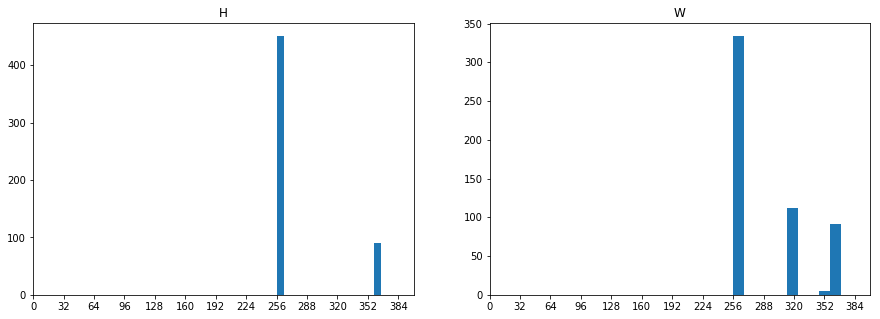

In [4]:
path2h5='../data/trainTestH'+str(IMG_HEIGHT)+'W'+str(IMG_WIDTH)+'.hdf5'
X,Y,HW_train=loadData(path2h5,'train')
array_stats(X)
array_stats(Y)
array_stats(HW_train)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(HW_train[:,0],100)
plt.xlim([0,400])
plt.xticks(range(0,400,32))
plt.title('H')
plt.subplot(1,2,2)
plt.hist(HW_train[:,1],100)
plt.xlim([0,400])
plt.xticks(range(0,400,32))
plt.title('W')
plt.show()

## Display data

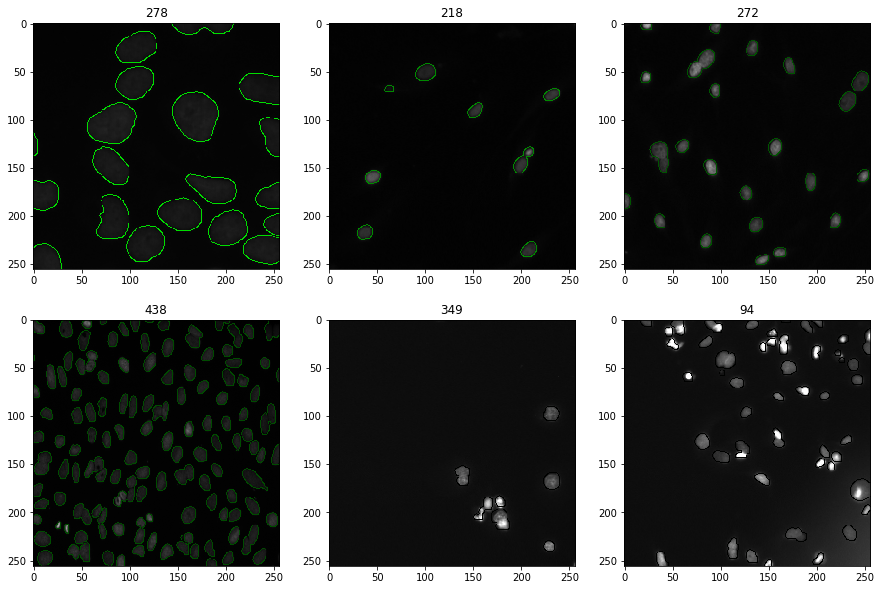

In [5]:
plt.figure(figsize=(15,10))
disp_img_2masks(img=X,mask1=Y,r=2,c=3)

## AI model

In [8]:
from keras.layers import Input, merge, Convolution2D, Deconvolution2D, AtrousConvolution2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers import Concatenate
from keras.layers import AtrousConv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers import Activation,Reshape,Permute
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU,PReLU,LeakyReLU
from keras.regularizers import l2

def conv2dcustom(x_input,filters=8,kernel_size=3,strides=1,w2reg=None,pool=False,padding='same',batchNorm=False,activation='relu'):
    data_format='channels_first'
    x1 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding,data_format=data_format,kernel_regularizer=w2reg,strides=strides)(x_input)
    if batchNorm:
        x1=BatchNormalization(axis=1)(x1)
        
    if activation=='leaky':        
        x1 = LeakyReLU(0.1)(x1)
    else:
        conv1=Activation('relu')(conv1)        

    if pool:
        x1=MaxPooling2D(pool_size=(2, 2),data_format=data_format)(x1)
    
    return x1


# model
def model_skip(params):

    h=params['h']
    w=params['w']
    z=params['z']
    lr=params['learning_rate']
    loss=params['loss']
    C=params['initial_channels']
    nb_output=params['num_labels']
    dropout_rate=params['dropout_rate']
    data_format='channels_first'
    batchNorm=params['batchNorm']
    w2reg=params['w2reg']
    initStride=params['initStride']
    reshape4softmax=params['reshape4softmax']
    
    
    inputs = Input((z,h, w))
    conv1=conv2dcustom(filters=C,x_input=inputs,strides=initStride,w2reg=w2reg,activation='leaky')    
    pool1=conv2dcustom(filters=C,x_input=conv1,w2reg=w2reg,pool=True,activation='leaky')    

    conv2=conv2dcustom(filters=2*C,x_input=pool1,w2reg=w2reg,activation='leaky')    
    pool2=conv2dcustom(filters=2*C,x_input=conv2,w2reg=w2reg,pool=True,activation='leaky')    
    
    conv3=conv2dcustom(filters=4*C,x_input=pool2,w2reg=w2reg,activation='leaky')    
    pool3=conv2dcustom(filters=4*C,x_input=conv3,w2reg=w2reg,pool=True,activation='leaky')    

    conv4=conv2dcustom(filters=8*C,x_input=pool3,w2reg=w2reg,activation='leaky')    
    pool4=conv2dcustom(filters=8*C,x_input=conv4,w2reg=w2reg,pool=True,activation='leaky')    

    conv5=conv2dcustom(filters=16*C,x_input=pool4,w2reg=w2reg,activation='leaky')    
    conv5=conv2dcustom(filters=16*C,x_input=conv5,w2reg=w2reg,pool=False,activation='leaky')    
    
    # dropout
    conv5 =Dropout(dropout_rate)(conv5)
    
    up7=UpSampling2D(size=(2, 2),data_format=data_format)(conv5)
    concat = Concatenate(axis=1)
    up7 = concat([up7, conv4])

    conv7=conv2dcustom(filters=8*C,x_input=up7,w2reg=w2reg,pool=False,activation='leaky')    
    
    up8 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv7), conv3])

    conv8=conv2dcustom(filters=4*C,x_input=up8,w2reg=w2reg,pool=False,activation='leaky')        
    
    up9 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv8), conv2])
    
    conv9=conv2dcustom(filters=2*C,x_input=up9,w2reg=w2reg,pool=False,activation='leaky')        

    up10 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv9), conv1])
    conv10=conv2dcustom(filters=C,x_input=up10,w2reg=w2reg,pool=False,activation='leaky')        

    conv10 = UpSampling2D(size=(initStride, initStride),data_format=data_format)(conv10)
    conv10=conv2dcustom(filters=C,x_input=conv10,w2reg=w2reg,pool=False,activation='leaky')        
    
    conv10 = Conv2D(nb_output, 1, data_format=data_format,kernel_regularizer=w2reg)(conv10)

    if reshape4softmax:
        # reshape for softmax
        output=Reshape((nb_output,h*w)) (conv10)
        # permute for softmax
        output=Permute((2,1))(output)
        # softmax
        output=Activation('softmax')(output)
    else:        
        output=Activation('sigmoid')(conv10)
    
    model = Model(inputs=inputs, outputs=output)

    if loss=='dice':
        model.compile(optimizer=Adam(lr), loss=dice_coef_loss, metrics=[dice_coef])
    else:
        #model.compile(loss='binary_crossentropy', optimizer=Adam(lr))
        model.compile(loss=loss, optimizer=Adam(lr))
    
    return model

In [10]:
n,z,h,w=X.shape
params_train={
    'h': h,
    'w': w,
    'z':z,
    'learning_rate': initialLearningRate,
    'optimizer': 'Adam',
    #'loss': 'categorical_crossentropy',
    'loss': 'binary_crossentropy',
    'nbepoch': 300 ,
    'num_labels': 1,
    'initial_channels':32,
    'dropout_rate': 0.5,
    'max_patience': 30,
    'experiment': None,
    'pre_train': False,
    'elastic_arg': None,
    'trainaug_params': None,
    'batch_size': 10,
    'weightfolder': None,
    'w2reg': l2(1e-4),    
    'batchNorm': False,
    'initStride': 2,
    'norm_type': norm_type,
    'augmentation': True,
    'reshape4softmax': False,
    }
    
model = model_skip(params_train)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 128, 128) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 9248        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

Total params: 7,072,065
Trainable params: 7,072,065
Non-trainable params: 0
__________________________________________________________________________________________________


wait ...
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.7, std:69.1
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.151, std:0.358
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 41.1, std:63.1
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.15, std:0.357
------------------------------
('experiment:', 'trainTest5_hw_256by256_initfilts_32')
weights folder created
batch_size: 10, Augmentation: True
fold 1 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.487944906772, score_test: 0.39285464785
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.33635717492, score_test: 0.320597787846
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  Current Learning Rate: 3.0e-04
score_train: 0.282311602414, score_test: 0.280584874883
!!!!!!!!!!!!

epoch: 51,  Current Learning Rate: 3.0e-04
score_train: 0.101459633923, score_test: 0.112077920851
epoch: 52,  Current Learning Rate: 3.0e-04
score_train: 0.099916529868, score_test: 0.106422815639
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 53,  Current Learning Rate: 3.0e-04
score_train: 0.100255639053, score_test: 0.107510227432
epoch: 54,  Current Learning Rate: 3.0e-04
score_train: 0.0971825611878, score_test: 0.104631688946
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 55,  Current Learning Rate: 3.0e-04
score_train: 0.0956551481292, score_test: 0.105399121544
epoch: 56,  Current Learning Rate: 3.0e-04
score_train: 0.0943447945155, score_test: 0.104549631032
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 57,  Current Learning Rate: 3.0e-04
score_train: 0.0956813949801, score_test: 0.112791550971
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0956999707355, score_test:

epoch: 118,  Current Learning Rate: 3.0e-04
score_train: 0.0668385824618, score_test: 0.0782980496314
epoch: 119,  Current Learning Rate: 3.0e-04
score_train: 0.0675707817275, score_test: 0.0758905168345
epoch: 120,  Current Learning Rate: 3.0e-04
score_train: 0.0664093721887, score_test: 0.0805570019492
epoch: 121,  Current Learning Rate: 3.0e-04
score_train: 0.0676847903327, score_test: 0.0788533390124
epoch: 122,  Current Learning Rate: 3.0e-04
score_train: 0.0669333849467, score_test: 0.0773855505039
epoch: 123,  Current Learning Rate: 3.0e-04
score_train: 0.0663271791133, score_test: 0.0761000723092
epoch: 124,  Current Learning Rate: 3.0e-04
score_train: 0.0661369463673, score_test: 0.0856178481855
epoch: 125,  Current Learning Rate: 3.0e-04
score_train: 0.0680776388689, score_test: 0.0795433443429
epoch: 126,  Current Learning Rate: 3.0e-04
score_train: 0.0684759929208, score_test: 0.0746963436145
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 12

score_train: 0.060613470396, score_test: 0.0725244782976
epoch: 192,  Current Learning Rate: 3.0e-04
score_train: 0.0603469568946, score_test: 0.0719697596088
epoch: 193,  Current Learning Rate: 3.0e-04
score_train: 0.0678673420243, score_test: 0.0961524635109
epoch: 194,  Current Learning Rate: 3.0e-04
score_train: 2.01336539707, score_test: 2.48735656133
epoch: 195,  Current Learning Rate: 3.0e-04
score_train: 2.24753341291, score_test: 2.47905556302
epoch: 196,  Current Learning Rate: 3.0e-04
score_train: 2.24284557002, score_test: 2.47334852147
epoch: 197,  Current Learning Rate: 3.0e-04
score_train: 2.2488719393, score_test: 2.46905247845
epoch: 198,  Current Learning Rate: 3.0e-04
score_train: 2.24807304174, score_test: 2.46559255337
epoch: 199,  Current Learning Rate: 3.0e-04
score_train: 2.23790445336, score_test: 2.46269336209
epoch: 200,  Current Learning Rate: 3.0e-04
score_train: 2.23406803311, score_test: 2.46020046277
epoch: 201,  Current Learning Rate: 3.0e-04
score_trai

score_train: 2.21380968157, score_test: 2.44111389011
epoch: 276,  Current Learning Rate: 3.0e-04
score_train: 2.20598769662, score_test: 2.44048801465
epoch: 277,  Current Learning Rate: 3.0e-04
score_train: 2.21943232056, score_test: 2.43989482922
epoch: 278,  Current Learning Rate: 3.0e-04
score_train: 2.21108858463, score_test: 2.43933123439
epoch: 279,  Current Learning Rate: 3.0e-04
score_train: 2.207541788, score_test: 2.43879665723
epoch: 280,  Current Learning Rate: 3.0e-04
score_train: 2.21265943054, score_test: 2.43828670125
epoch: 281,  Current Learning Rate: 3.0e-04
score_train: 2.20909384985, score_test: 2.4378005711
epoch: 282,  Current Learning Rate: 3.0e-04
score_train: 2.211586473, score_test: 2.43733591998
epoch: 283,  Current Learning Rate: 3.0e-04
score_train: 2.20855095019, score_test: 2.43689198458
epoch: 284,  Current Learning Rate: 3.0e-04
score_train: 2.19746006662, score_test: 2.43646610851
epoch: 285,  Current Learning Rate: 3.0e-04
score_train: 2.2079314626

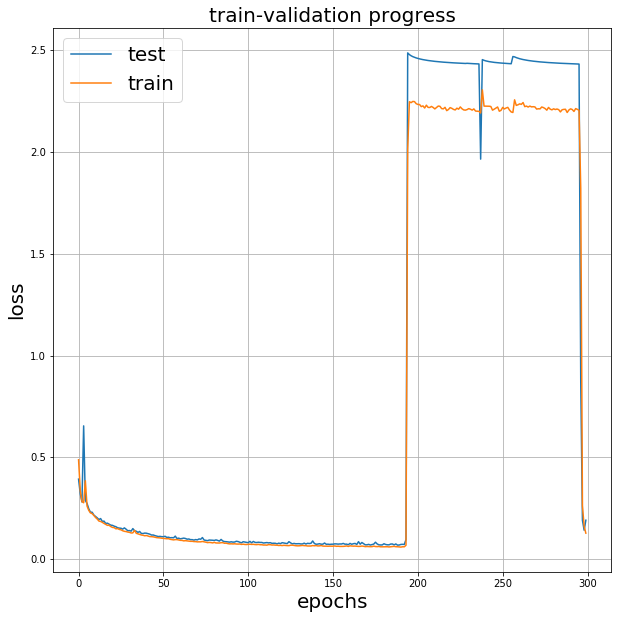

training completed!
weights loaded!
score_test: 0.06866
average dice: 0.92
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.6, std:68.5
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.15, std:0.357
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 41.6, std:68.6
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.164, std:0.371
------------------------------
('experiment:', 'trainTest5_hw_256by256_initfilts_32')
weights folder created
batch_size: 10, Augmentation: True
fold 2 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.724359360154, score_test: 0.468445349985
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.376853615886, score_test: 0.355829236223
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  

score_train: 0.0947173410968, score_test: 0.111440002029
epoch: 52,  Current Learning Rate: 3.0e-04
score_train: 0.0959038300869, score_test: 0.0980330819069
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 53,  Current Learning Rate: 3.0e-04
score_train: 0.0916446223731, score_test: 0.100043741402
epoch: 54,  Current Learning Rate: 3.0e-04
score_train: 0.0915921004257, score_test: 0.0984548050076
epoch: 55,  Current Learning Rate: 3.0e-04
score_train: 0.0909897299301, score_test: 0.0966237781208
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 56,  Current Learning Rate: 3.0e-04
score_train: 0.088730060602, score_test: 0.0947944275034
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 57,  Current Learning Rate: 3.0e-04
score_train: 0.0905692984487, score_test: 0.103067170551
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0976960822866, score_test: 0.0994958523939
epoch: 59,  Current 

score_train: 0.0683633562789, score_test: 0.0767098291596
epoch: 121,  Current Learning Rate: 3.0e-04
score_train: 0.0691380231559, score_test: 0.0779378983512
epoch: 122,  Current Learning Rate: 3.0e-04
score_train: 0.0688725337386, score_test: 0.0742953286242
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 123,  Current Learning Rate: 3.0e-04
score_train: 0.0715666065119, score_test: 0.0774580464879
epoch: 124,  Current Learning Rate: 3.0e-04
score_train: 0.0762741863357, score_test: 0.0771132082637
epoch: 125,  Current Learning Rate: 3.0e-04
score_train: 0.0740753272626, score_test: 0.0825454890728
epoch: 126,  Current Learning Rate: 3.0e-04
score_train: 0.0735314208798, score_test: 0.0767899598203
epoch: 127,  Current Learning Rate: 3.0e-04
score_train: 0.0696653074478, score_test: 0.0805902716829
epoch: 128,  Current Learning Rate: 3.0e-04
score_train: 0.0690056721357, score_test: 0.0789061157561
epoch: 129,  Current Learning Rate: 3.0e-04
score_tra

score_train: 0.0639436061357, score_test: 0.073026634864
epoch: 194,  Current Learning Rate: 3.0e-04
score_train: 0.0633788193772, score_test: 0.0732618230048
epoch: 195,  Current Learning Rate: 3.0e-04
score_train: 0.0621524022932, score_test: 0.068634662388
epoch: 196,  Current Learning Rate: 3.0e-04
score_train: 0.0619691984719, score_test: 0.0715459191532
epoch: 197,  Current Learning Rate: 3.0e-04
score_train: 0.0615916854639, score_test: 0.0704598273359
epoch: 198,  Current Learning Rate: 3.0e-04
score_train: 0.0621969584456, score_test: 0.0685458080982
epoch: 199,  Current Learning Rate: 3.0e-04
score_train: 0.0624435718417, score_test: 0.0698914496756
epoch: 200,  Current Learning Rate: 3.0e-04
score_train: 0.0620165731925, score_test: 0.0678906447407
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 201,  Current Learning Rate: 3.0e-04
score_train: 0.0614520951018, score_test: 0.0696640259294
epoch: 202,  Current Learning Rate: 3.0e-04
score_train

score_train: 2.18676496857, score_test: 2.66906533668
epoch: 273,  Current Learning Rate: 3.0e-04
score_train: 2.19177092802, score_test: 2.66858730743
epoch: 274,  Current Learning Rate: 3.0e-04
score_train: 2.18136922103, score_test: 2.6681235833
epoch: 275,  Current Learning Rate: 3.0e-04
score_train: 2.1909556634, score_test: 2.66767201851
epoch: 276,  Current Learning Rate: 3.0e-04
score_train: 2.18412340794, score_test: 2.66723356674
epoch: 277,  Current Learning Rate: 3.0e-04
score_train: 2.1879904116, score_test: 2.66680679748
epoch: 278,  Current Learning Rate: 3.0e-04
score_train: 2.19024614197, score_test: 2.66639075706
epoch: 279,  Current Learning Rate: 3.0e-04
score_train: 2.17518146141, score_test: 2.66598520706
epoch: 280,  Current Learning Rate: 3.0e-04
score_train: 2.18664136336, score_test: 2.66559014747
epoch: 281,  Current Learning Rate: 3.0e-04
score_train: 2.18546130349, score_test: 2.66520414779
epoch: 282,  Current Learning Rate: 3.0e-04
score_train: 2.18139557

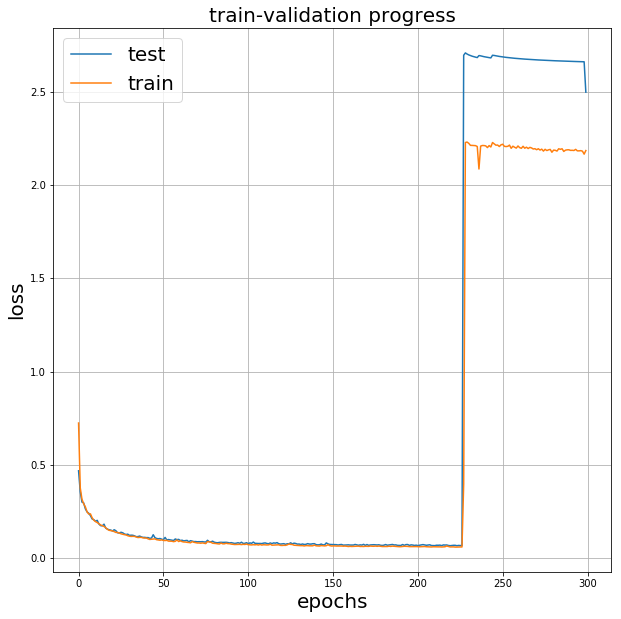

training completed!
weights loaded!
score_test: 0.06695
average dice: 0.91
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.2, std:68.2
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.151, std:0.358
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 45.6, std:70.7
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.15, std:0.357
------------------------------
('experiment:', 'trainTest5_hw_256by256_initfilts_32')
weights folder created
batch_size: 10, Augmentation: True
fold 3 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.748941531525, score_test: 0.417929074657
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.404735241314, score_test: 0.385070694916
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  

score_train: 0.09524756038, score_test: 0.102086058971
epoch: 52,  Current Learning Rate: 3.0e-04
score_train: 0.0948184887889, score_test: 0.093759315283
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 53,  Current Learning Rate: 3.0e-04
score_train: 0.0943312080914, score_test: 0.0961630136998
epoch: 54,  Current Learning Rate: 3.0e-04
score_train: 0.0939583780482, score_test: 0.0922361629
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 55,  Current Learning Rate: 3.0e-04
score_train: 0.0933323850605, score_test: 0.0945656867281
epoch: 56,  Current Learning Rate: 3.0e-04
score_train: 0.0901927783665, score_test: 0.0958340171891
epoch: 57,  Current Learning Rate: 3.0e-04
score_train: 0.0900715892489, score_test: 0.0918467403459
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0901800940063, score_test: 0.0966174767645
epoch: 59,  Current Lea

score_train: 2.24034307885, score_test: 2.45086232762
epoch: 119,  Current Learning Rate: 3.0e-04
score_train: 2.23509906556, score_test: 2.4492348397
epoch: 120,  Current Learning Rate: 3.0e-04
score_train: 2.23672279552, score_test: 2.44777431417
epoch: 121,  Current Learning Rate: 3.0e-04
score_train: 2.22528584245, score_test: 2.44645297171
epoch: 122,  Current Learning Rate: 3.0e-04
score_train: 2.23736894467, score_test: 2.44524753272
epoch: 123,  Current Learning Rate: 3.0e-04
score_train: 2.2262144664, score_test: 2.44414008909
epoch: 124,  Current Learning Rate: 3.0e-04
score_train: 2.23094535744, score_test: 2.44311770752
epoch: 125,  Current Learning Rate: 3.0e-04
score_train: 2.22192317653, score_test: 2.44216670385
epoch: 126,  Current Learning Rate: 3.0e-04
score_train: 2.22221658815, score_test: 2.44128026357
epoch: 127,  Current Learning Rate: 3.0e-04
score_train: 2.23052192209, score_test: 2.44045031249
epoch: 128,  Current Learning Rate: 3.0e-04
score_train: 2.2176425

score_train: 2.21342056901, score_test: 2.43455588462
epoch: 203,  Current Learning Rate: 3.0e-04
score_train: 2.21132896631, score_test: 2.43396056944
epoch: 204,  Current Learning Rate: 3.0e-04
score_train: 2.20756996409, score_test: 2.43338952492
epoch: 205,  Current Learning Rate: 3.0e-04
score_train: 2.21348470914, score_test: 2.4328397637
epoch: 206,  Current Learning Rate: 3.0e-04
score_train: 2.22295159586, score_test: 2.43231094595
epoch: 207,  Current Learning Rate: 3.0e-04
score_train: 2.21223660211, score_test: 2.43180026937
epoch: 208,  Current Learning Rate: 3.0e-04
score_train: 2.21457846762, score_test: 2.43130863425
epoch: 209,  Current Learning Rate: 3.0e-04
score_train: 2.21827531434, score_test: 2.43083296783
epoch: 210,  Current Learning Rate: 3.0e-04
score_train: 2.20717319248, score_test: 2.43037214208
epoch: 211,  Current Learning Rate: 3.0e-04
score_train: 2.21251386038, score_test: 2.42992653242
epoch: 212,  Current Learning Rate: 3.0e-04
score_train: 2.201269

score_train: 0.0817266322648, score_test: 0.0865441700305
epoch: 287,  Current Learning Rate: 3.0e-04
score_train: 0.0826268998989, score_test: 0.0973476097544
epoch: 288,  Current Learning Rate: 3.0e-04
score_train: 0.0811895598128, score_test: 0.083942650025
epoch: 289,  Current Learning Rate: 3.0e-04
score_train: 0.0787257407954, score_test: 0.0829165515059
epoch: 290,  Current Learning Rate: 3.0e-04
score_train: 0.0797640226818, score_test: 0.0954296129631
epoch: 291,  Current Learning Rate: 3.0e-04
score_train: 0.0781222299965, score_test: 0.0878210002695
epoch: 292,  Current Learning Rate: 3.0e-04
score_train: 0.0798852701932, score_test: 0.0889101288101
epoch: 293,  Current Learning Rate: 3.0e-04
score_train: 0.0804609541054, score_test: 0.0805962564451
epoch: 294,  Current Learning Rate: 3.0e-04
score_train: 0.0766026981509, score_test: 0.0798032308248
epoch: 295,  Current Learning Rate: 3.0e-04
score_train: 0.0766749897814, score_test: 0.0811302023036
epoch: 296,  Current Lear

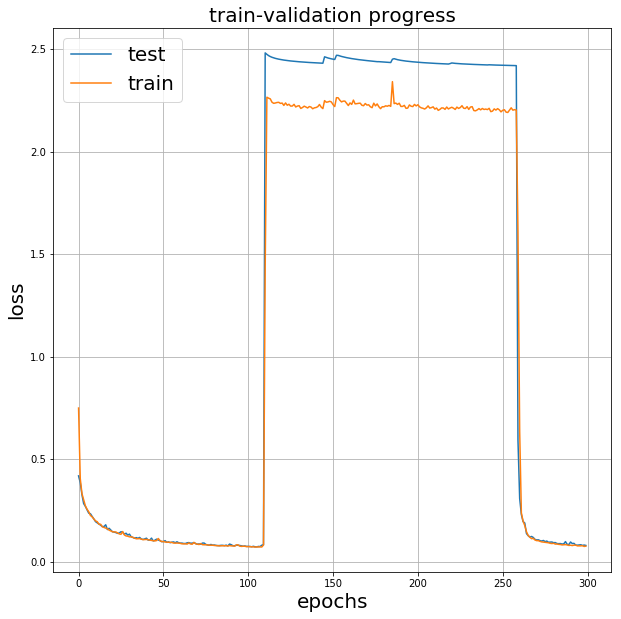

training completed!
weights loaded!
score_test: 0.07155
average dice: 0.90
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.9, std:68.7
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.152, std:0.359
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 38.9, std:66.9
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.142, std:0.349
------------------------------
('experiment:', 'trainTest5_hw_256by256_initfilts_32')
weights folder created
batch_size: 10, Augmentation: True
fold 4 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.824473513497, score_test: 0.574569527783
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.388398749862, score_test: 0.328023630736
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2, 

score_train: 2.28113745358, score_test: 2.36194835492
epoch: 54,  Current Learning Rate: 3.0e-04
score_train: 2.29017981328, score_test: 2.36032613356
epoch: 55,  Current Learning Rate: 3.0e-04
score_train: 2.28910715544, score_test: 2.35875188771
epoch: 56,  Current Learning Rate: 3.0e-04
score_train: 2.28106840733, score_test: 2.35722459964
epoch: 57,  Current Learning Rate: 3.0e-04
score_train: 2.26709870043, score_test: 2.35573947963
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 2.26285999924, score_test: 2.35429516123
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 2.28849652632, score_test: 2.35288963033
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 2.26968892811, score_test: 2.35151920034
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 2.27974591129, score_test: 2.35018289623
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 2.27014458743, score_test: 2.34887947253
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 2.27371784664, sc

score_train: 2.22502757997, score_test: 2.30174066771
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 2.23062885757, score_test: 2.30128051274
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 2.21900008923, score_test: 2.30084275488
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 2.21440591701, score_test: 2.30037159706
epoch: 142,  Current Learning Rate: 3.0e-04
score_train: 2.04418267757, score_test: 2.04341020157
epoch: 143,  Current Learning Rate: 3.0e-04
score_train: 2.27386029206, score_test: 2.36912599962
epoch: 144,  Current Learning Rate: 3.0e-04
score_train: 2.28818085439, score_test: 2.36532510928
epoch: 145,  Current Learning Rate: 3.0e-04
score_train: 2.30015780153, score_test: 2.36188136998
epoch: 146,  Current Learning Rate: 3.0e-04
score_train: 2.28709175693, score_test: 2.35883058719
epoch: 147,  Current Learning Rate: 3.0e-04
score_train: 2.29137572859, score_test: 2.35608196259
epoch: 148,  Current Learning Rate: 3.0e-04
score_train: 2.27933

score_train: 0.165370280124, score_test: 0.165248342859
epoch: 223,  Current Learning Rate: 3.0e-04
score_train: 0.151501503416, score_test: 0.137727469651
epoch: 224,  Current Learning Rate: 3.0e-04
score_train: 0.141716679864, score_test: 0.128892907456
epoch: 225,  Current Learning Rate: 3.0e-04
score_train: 0.200819407431, score_test: 0.175674365528
epoch: 226,  Current Learning Rate: 3.0e-04
score_train: 0.156078604546, score_test: 0.149022117035
epoch: 227,  Current Learning Rate: 3.0e-04
score_train: 0.148615471413, score_test: 0.130322250412
epoch: 228,  Current Learning Rate: 3.0e-04
score_train: 0.129558262009, score_test: 0.126710363288
epoch: 229,  Current Learning Rate: 3.0e-04
score_train: 0.146234069396, score_test: 0.129949950015
epoch: 230,  Current Learning Rate: 3.0e-04
score_train: 0.127156179516, score_test: 0.114751108547
epoch: 231,  Current Learning Rate: 3.0e-04
score_train: 0.118489081772, score_test: 0.105885248576
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvemen

epoch: 288,  Current Learning Rate: 3.0e-04
score_train: 0.0719398911888, score_test: 0.0688915506228
epoch: 289,  Current Learning Rate: 3.0e-04
score_train: 0.0725492771227, score_test: 0.0664180110195
epoch: 290,  Current Learning Rate: 3.0e-04
score_train: 0.0738441987491, score_test: 0.0736933862095
epoch: 291,  Current Learning Rate: 3.0e-04
score_train: 0.0733001818433, score_test: 0.066385638358
epoch: 292,  Current Learning Rate: 3.0e-04
score_train: 0.0715464335522, score_test: 0.0655071397326
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 293,  Current Learning Rate: 3.0e-04
score_train: 0.072315400352, score_test: 0.0685304383289
epoch: 294,  Current Learning Rate: 3.0e-04
score_train: 0.0724895535343, score_test: 0.0672206227014
epoch: 295,  Current Learning Rate: 3.0e-04
score_train: 0.0750390028281, score_test: 0.0692660601726
epoch: 296,  Current Learning Rate: 3.0e-04
score_train: 0.0703672023913, score_test: 0.0648703339385
!!!!!!!!!!!

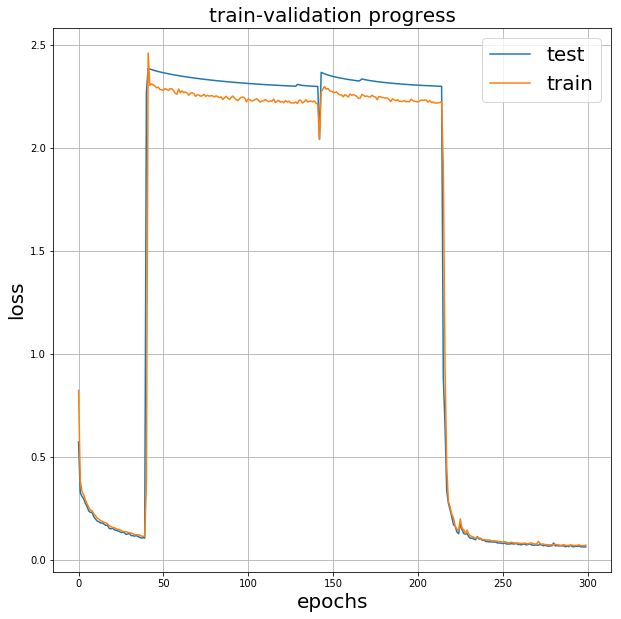

training completed!
weights loaded!
score_test: 0.06410
average dice: 0.89
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 44.1, std:69.2
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.153, std:0.36
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 37.0, std:61.3
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.133, std:0.34
------------------------------
('experiment:', 'trainTest5_hw_256by256_initfilts_32')
weights folder created
batch_size: 10, Augmentation: True
fold 5 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.763335944408, score_test: 0.457575929699
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.373116938728, score_test: 0.350635204742
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  C

score_train: 0.0951963538925, score_test: 0.0955476780881
epoch: 50,  Current Learning Rate: 3.0e-04
score_train: 0.0946239146155, score_test: 0.0948517763459
epoch: 51,  Current Learning Rate: 3.0e-04
score_train: 0.09644299365, score_test: 0.0946739669055
epoch: 52,  Current Learning Rate: 3.0e-04
score_train: 0.0924643690931, score_test: 0.0971672333666
epoch: 53,  Current Learning Rate: 3.0e-04
score_train: 0.093471925996, score_test: 0.0973993628216
epoch: 54,  Current Learning Rate: 3.0e-04
score_train: 0.0917881427713, score_test: 0.0966301971296
epoch: 55,  Current Learning Rate: 3.0e-04
score_train: 0.0896446432171, score_test: 0.0926715850052
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 56,  Current Learning Rate: 3.0e-04
score_train: 0.0893755735919, score_test: 0.0973038602231
epoch: 57,  Current Learning Rate: 3.0e-04
score_train: 0.0912445569179, score_test: 0.0947504929865
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.090837

score_train: 0.0692423638482, score_test: 0.0778538510203
epoch: 119,  Current Learning Rate: 3.0e-04
score_train: 0.0693335147269, score_test: 0.0730754359445
epoch: 120,  Current Learning Rate: 3.0e-04
score_train: 0.0681610077582, score_test: 0.0699540768653
epoch: 121,  Current Learning Rate: 3.0e-04
score_train: 0.0687041157983, score_test: 0.0700158416224
epoch: 122,  Current Learning Rate: 3.0e-04
score_train: 0.066635035207, score_test: 0.070657750397
epoch: 123,  Current Learning Rate: 3.0e-04
score_train: 0.0727445445893, score_test: 0.0713561659873
epoch: 124,  Current Learning Rate: 3.0e-04
score_train: 0.0695689298386, score_test: 0.0687490268541
epoch: 125,  Current Learning Rate: 3.0e-04
score_train: 0.0688619398656, score_test: 0.0678086423718
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 126,  Current Learning Rate: 3.0e-04
score_train: 0.0698422491056, score_test: 0.0694006920528
epoch: 127,  Current Learning Rate: 3.0e-04
score_train

score_train: 2.22856776117, score_test: 2.15172584377
epoch: 199,  Current Learning Rate: 3.0e-04
score_train: 2.23531190871, score_test: 2.15152769658
epoch: 200,  Current Learning Rate: 3.0e-04
score_train: 2.22793159951, score_test: 2.15133512198
epoch: 201,  Current Learning Rate: 3.0e-04
score_train: 2.23139563761, score_test: 2.15114732643
epoch: 202,  Current Learning Rate: 3.0e-04
score_train: 2.22865782013, score_test: 2.15096348435
epoch: 203,  Current Learning Rate: 3.0e-04
score_train: 2.22050920361, score_test: 2.15078449961
epoch: 204,  Current Learning Rate: 3.0e-04
score_train: 2.22817453935, score_test: 2.15060947902
epoch: 205,  Current Learning Rate: 3.0e-04
score_train: 2.22982806373, score_test: 2.15043322364
epoch: 206,  Current Learning Rate: 3.0e-04
score_train: 2.18044179233, score_test: 2.18293851525
epoch: 207,  Current Learning Rate: 3.0e-04
score_train: 2.26719466687, score_test: 2.17719286591
epoch: 208,  Current Learning Rate: 3.0e-04
score_train: 2.24866

score_train: 0.0973526390754, score_test: 0.0983749867153
epoch: 283,  Current Learning Rate: 3.0e-04
score_train: 0.096858229519, score_test: 0.0956050481147
epoch: 284,  Current Learning Rate: 3.0e-04
score_train: 0.0948654030315, score_test: 0.0977853243587
epoch: 285,  Current Learning Rate: 3.0e-04
score_train: 0.09354624639, score_test: 0.0970672231668
epoch: 286,  Current Learning Rate: 3.0e-04
score_train: 0.0918325460323, score_test: 0.101042103856
epoch: 287,  Current Learning Rate: 3.0e-04
score_train: 0.095965517101, score_test: 0.093389106831
epoch: 288,  Current Learning Rate: 3.0e-04
score_train: 0.0905729613914, score_test: 0.0921699210668
epoch: 289,  Current Learning Rate: 3.0e-04
score_train: 0.0900005879217, score_test: 0.0992049654362
epoch: 290,  Current Learning Rate: 3.0e-04
score_train: 0.0890374703589, score_test: 0.08941344194
epoch: 291,  Current Learning Rate: 3.0e-04
score_train: 0.0903391773947, score_test: 0.0985000392061
epoch: 292,  Current Learning Ra

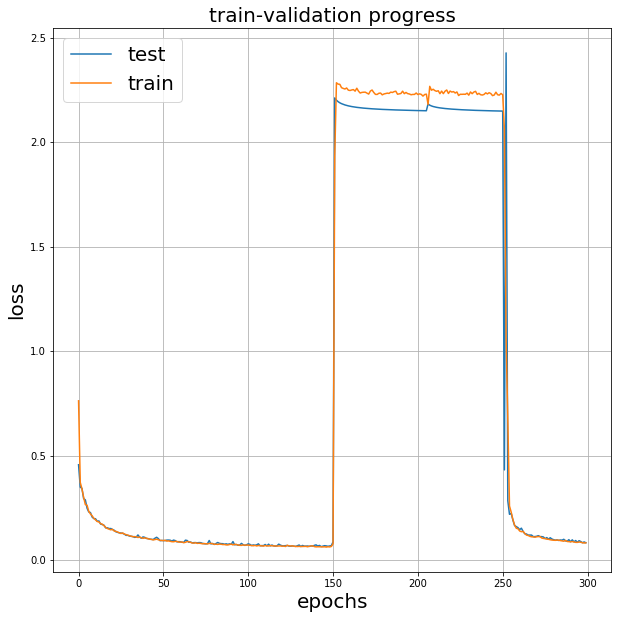

training completed!
weights loaded!
score_test: 0.06604
average dice: 0.90
------------------------------
average score for 5 folds is 0.0674603405617


In [11]:
n_folds=5
skf = ShuffleSplit(n_splits=n_folds, test_size=0.1, random_state=321)

# loop over folds
foldnm=0
scores_nfolds=[]

print ('wait ...')
for train_ind, test_ind in skf.split(X,Y):
    foldnm+=1    

    train_ind=list(np.sort(train_ind))
    test_ind=list(np.sort(test_ind))
    
    X_train,Y_train=X[train_ind],np.array(Y[train_ind],'uint8')
    X_test,Y_test=X[test_ind],np.array(Y[test_ind],'uint8')
    
    array_stats(X_train)
    array_stats(Y_train)
    array_stats(X_test)
    array_stats(Y_test)
    print ('-'*30)

    # exeriment name to record weights and scores
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['initial_channels'])
    print ('experiment:', experiment)

    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    if  not os.path.exists(weightfolder):
        os.makedirs(weightfolder)
        print ('weights folder created')    
    
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    path2model=weightfolder+"/model.hdf5"    
    
    # train test on fold #
    params_train['foldnm']=foldnm
    params_train['learning_rate']=initialLearningRate
    params_train['path2weights']=path2weights
    params_train['path2model']=path2model
    model=model_skip(params_train)
    #model.summary()    
    train_test_model(X_train,Y_train,X_test,Y_test,params_train)
    
    # loading best weights from training session
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print 'weights loaded!'
    else:
        raise IOError('weights does not exist!!!')
    
    score_test=model.evaluate(preprocess(X_test,norm_type),Y_test,verbose=0,batch_size=8)
    print ('score_test: %.5f' %(score_test))    
    Y_pred=model.predict(preprocess(X_test,norm_type))>0.5
    dicePerFold,_=calc_dice(Y_test,Y_pred)
    print('average dice: %.2f' %dicePerFold)
    print ('-' *30)
    # store scores for all folds
    scores_nfolds.append(score_test)

print ('average score for %s folds is %s' %(n_folds,np.mean(scores_nfolds)))    

### diaply predictions

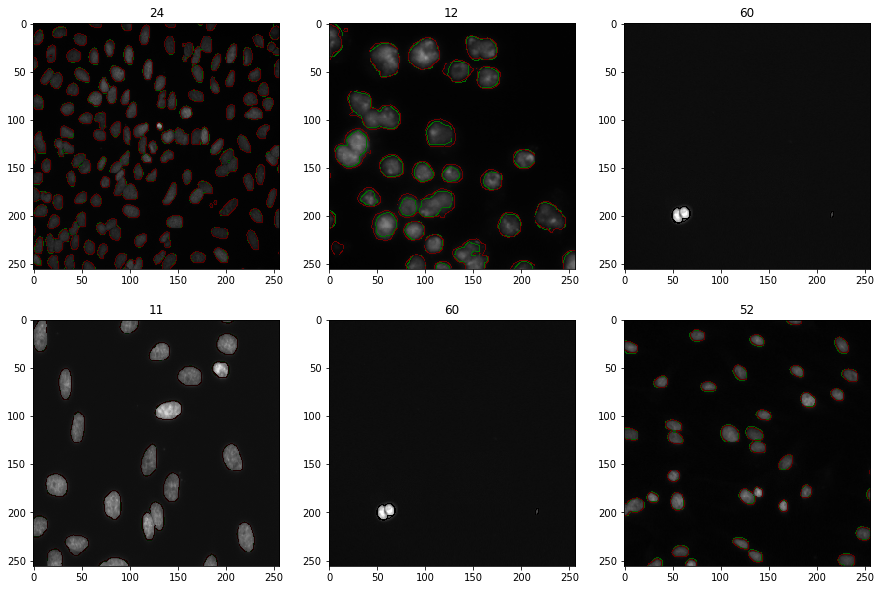

In [12]:
plt.figure(figsize=(15,10))
disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)

### display after resizing

('array shape: ', (256, 320), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.362, std:0.472
('array shape: ', (3, 256, 320), dtype('uint8'))
min: 16, max: 232, avg: 1.74e+02, std:46.9


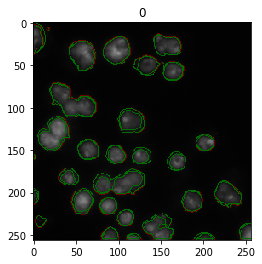

In [13]:
Y_testResized=resizeY(Y_pred,HW_train[test_ind])
X_testResized=resizeX(X_test,HW_train[test_ind])
array_stats(Y_testResized[0])
array_stats(X_testResized[0])

#disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)
n1=np.random.randint(len(X_testResized))
disp_img_2masks(X_testResized[n1][np.newaxis],Y_testResized[n1][np.newaxis,np.newaxis],r=1,c=1)

## Predict on Leaderboard Data

loading ../data/trainTestH256W256.hdf5
('array shape: ', (65, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 53.4, std:74.8
('array shape: ', (65, 3), dtype('uint16'))
min: 3, max: 696, avg: 2.66e+02, std:2.28e+02


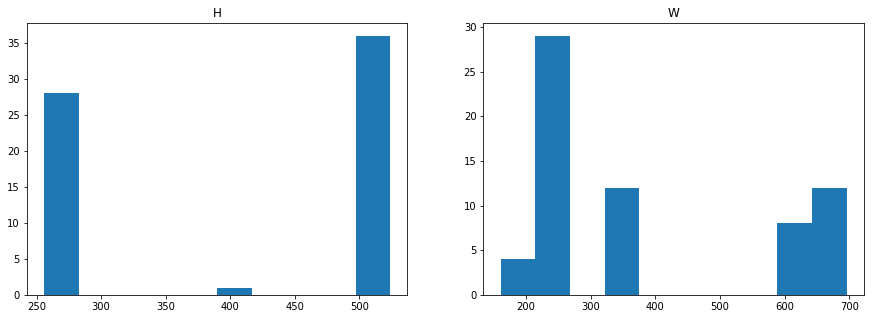

fold: 1
experiment: trainTest5_hw_256by256_initfilts_32
./output/weights/trainTest5_hw_256by256_initfilts_32/fold1/weights.hdf5 loaded!
('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.149, std:0.318
--------------------------------------------------
fold: 2
experiment: trainTest5_hw_256by256_initfilts_32
./output/weights/trainTest5_hw_256by256_initfilts_32/fold2/weights.hdf5 loaded!
('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 7.25676472258e-16, max: 1.0, avg: 0.157, std:0.324
--------------------------------------------------
fold: 3
experiment: trainTest5_hw_256by256_initfilts_32
./output/weights/trainTest5_hw_256by256_initfilts_32/fold3/weights.hdf5 loaded!
('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 1.02440164641e-15, max: 1.0, avg: 0.142, std:0.31
--------------------------------------------------
fold: 4
experiment: trainTest5_hw_256by256_initfilts_32
./output/weights/trainTest5_hw_256by256_initfilts_32/fold4/weight

In [14]:
X_leader,_,HW_leader=loadData(path2h5,'leader')
array_stats(X_leader)
array_stats(HW_leader)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(HW_leader[:,0])
plt.title('H')
plt.subplot(1,2,2)
plt.hist(HW_leader[:,1])
plt.title('W')
plt.show()

n_folds=5
# prediction for nfolds
Y_leaderAllFolds=[]
for foldnm in range(1,n_folds+1):
    print('fold: %s' %foldnm)
    # load weights
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['initial_channels'])
    print ('experiment: %s' %experiment)
    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print ('%s loaded!' %path2weights)
    else:
        raise IOError ('weights does not exist!')

    # prediction
    Y_leader_perfold=model.predict(preprocess(X_leader.value,norm_type))
    array_stats(Y_leader_perfold)
    Y_leaderAllFolds.append(Y_leader_perfold)        
    print('-'*50)

# convert to array
Y_leader=np.hstack(Y_leaderAllFolds)
print ('ensemble shape:', Y_leader.shape)
Y_leader=np.mean(Y_leader,axis=1)[:,np.newaxis]
array_stats(Y_leader)

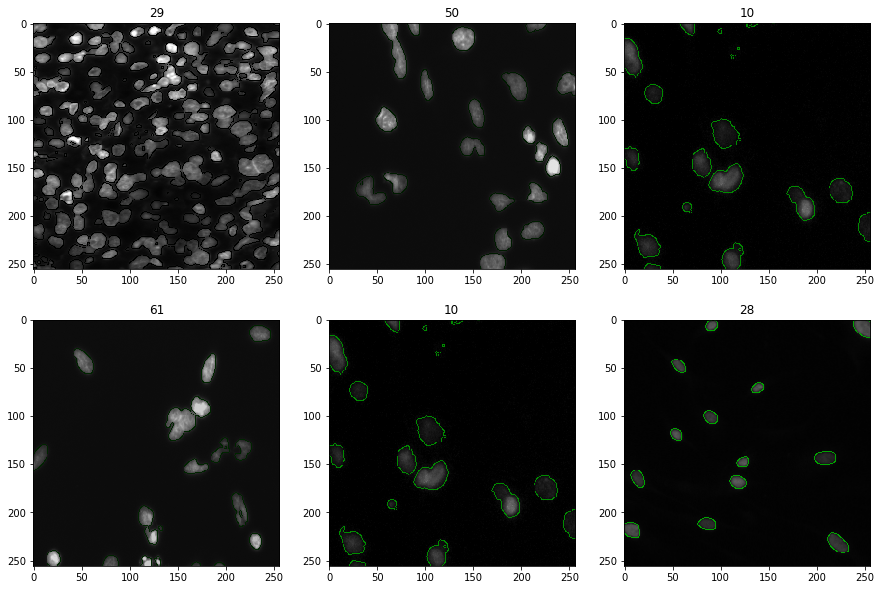

In [15]:
plt.figure(figsize=(15,10))
disp_img_2masks(X_leader,Y_leader>0.5,r=2,c=3)

### display after resizing 

('array shape: ', (256, 256), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.0174, std:0.131
('array shape: ', (3, 256, 256), dtype('uint8'))
min: 1, max: 77, avg: 3.93, std:4.88
('array shape: ', (512, 640), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.0933, std:0.284
('array shape: ', (3, 512, 640), dtype('uint8'))
min: 0, max: 139, avg: 11.7, std:13.3
35 7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04


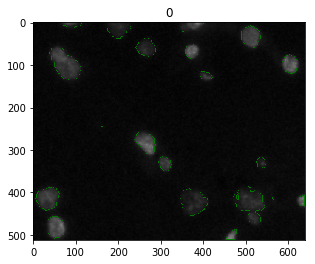

In [18]:
Y_leaderResized=resizeY(Y_leader>0.5,HW_leader)
X_leaderResized=resizeX(X_leader,HW_leader)
array_stats(Y_leaderResized[0])
array_stats(X_leaderResized[0])

#disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)
n1=np.random.randint(len(X_leaderResized))
array_stats(Y_leaderResized[n1])
array_stats(X_leaderResized[n1])
print n1,test_ids[n1]
disp_img_2masks(X_leaderResized[n1][np.newaxis],Y_leaderResized[n1][np.newaxis,np.newaxis],r=1,c=1)

In [19]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
        

In [20]:
array_stats(Y_leader)
Y_leaderResized=resizeY(Y_leader,HW_leader)
array_stats(Y_leaderResized[0])

new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(Y_leaderResized[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 3.29767768648e-10, max: 1.0, avg: 0.153, std:0.315
('array shape: ', (256, 256), dtype('float64'))
min: 2.28167918976e-05, max: 0.999812304974, avg: 0.0184, std:0.125


In [21]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

now = datetime.datetime.now()
info=experiment
suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
submissionFolder='./output/submissions'
if not os.path.exists(submissionFolder):
    os.mkdir(submissionFolder)
    print(submissionFolder+ ' created!')
path2submission = os.path.join(submissionFolder, 'submission_' + suffix + '.csv')
print(path2submission)
sub.to_csv(path2submission, index=False)
sub.head()

./output/submissions/submission_trainTest5_hw_256by256_initfilts_32_2018-02-04-20-13.csv


,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 9 45359 11 45613 14 45869 14 46124 15 46...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,27992 2 28248 2 28504 2
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50025 4 50278 10 50533 12 50788 14 51042 16 51...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10892 6 11146 9 11401 10 11656 12 11911 13 121...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31630 9 31884 13 32138 15 32393 17 32648 18 32...
